# Demo de implementación de un Algoritmo Genético (AG) para resolver el problema de encontrar un Máximo Óptimo definido al azar en un plano y tratando de esquivar los máximos locales aleatorios
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

In [1]:
#@title Instalar librerías
# instala DEAP
!pip install deap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.1 MB/s eta 0:00:00


In [2]:
#@title Cargar Librerías
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from deap import base
from deap import creator
from deap import tools

import pickle
import codecs

import matplotlib
import matplotlib.pyplot as plt
import networkx
from IPython.display import display
from PIL import Image

import matplotlib as mpl
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import ipywidgets as widgets
from ipywidgets import Box, Layout, IntSlider
from ipywidgets import Layout
from IPython.display import clear_output

print("\nLibrerías importadas")


Librerías importadas


In [3]:
#@title PARÁMETROS

#@markdown Parámetros del Espacio de búsqueda:
CANT_MAXIMOS_LOCALES = 3 #@param {type:"slider", min:0, max:10, step:1}
MIN_ESPACIO_BUSQ = -1000 #@param {type:"slider", min:-1000, max:0, step:10}
MAX_ESPACIO_BUSQ = 1000  #@param {type:"slider", min:0, max:1000, step:10}

#@markdown Parámetros del Algoritmo Genético:

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 150 #@param {type:"integer"}

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 35  #@param {type:"slider", min:1, max:100, step:1}

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos



Clase Mapa de Búqueda definida

> Usando configuración de mapa de búsqueda definida en hash.

> Mapa de búsqueda definido:

** Máximos Generados:  4
  --> [100, 100] {  100  } 
  --> [-500, -500] {  50  } 
  --> [600, 600] {  60  } 
  --> [-111, -111] {  -11  } 

** Posición Máximo Óptimo:  [100, 100]  {  100  } **



> Hash del mapa de búsqueda definido: 
gASVxQAAAAAAAACMCF9fbWFpbl9flIwMTWFwYUJ1c3F1ZWRhlJOUKYGUfZQojAZsaW1NaW6UShj8
//+MBmxpbU1heJRN6AOMB2NhbnRNYXiUSwOMCk1heGltb3NQb3OUXZQoXZQoS2RLZGVdlChKDP7/
/0oM/v//ZV2UKE1YAk1YAmVdlChKkf///0qR////ZWWMCk1heGltb3NWYWyUXZQoS2RLMks8SvX/
//9ljAtNYXhPcHRpbW9JRJRLAIwBWJROjAFZlE6MAVqUTnViLg==


> Gráfico en 2D del Mapa de Búsqueda:


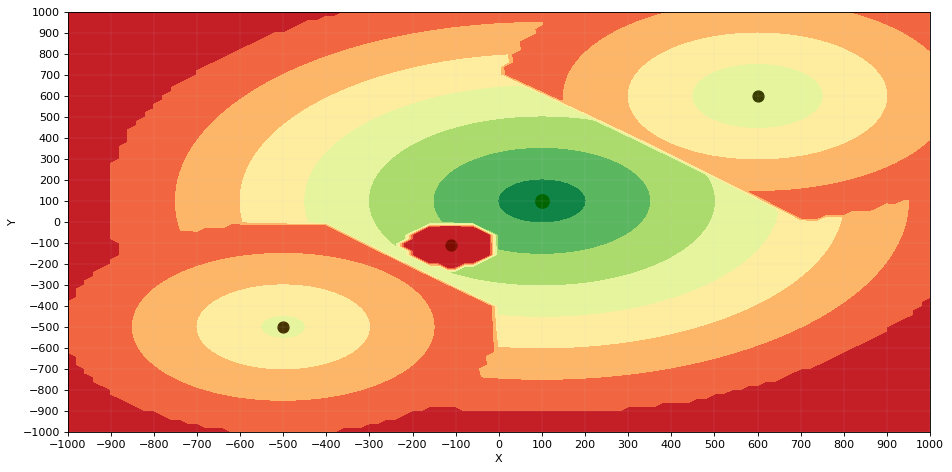

(NOTA: color más ROJO significa PEOR aptitud, y más VERDE es MEJOR aptitud)

> Gráfico en 3D del Mapa de Búsqueda:


Output()

In [4]:
#@title clase MAPA DE BÚSQUEDA
Hash_configuracion_Mapa_Busqueda = "gANjX19tYWluX18KTWFwYUJ1c3F1ZWRhCnEAKYFxAX1xAihYBgAAAGxpbU1pbnEDShj8//9YBgAA AGxpbU1heHEETegDWAcAAABjYW50TWF4cQVLA1gKAAAATWF4aW1vc1Bvc3EGXXEHKF1xCChLZEtk ZV1xCShKDP7//0oM/v//ZV1xCihNWAJNWAJlXXELKEqR////SpH///9lZVgKAAAATWF4aW1vc1Zh bHEMXXENKEtkSzJLPEr1////ZVgLAAAATWF4T3B0aW1vSURxDksAWAEAAABYcQ9OWAEAAABZcRBO WAEAAABacRFOdWIu" #@param {type:"string"}

class MapaBusqueda(object):

    def __init__(self, limMin, limMax, cantMaximosLocales=0):
          self.limMin = limMin
          self.limMax = limMax
          self.cantMax = cantMaximosLocales
          self.X, self.Y, self.Z = None, None, None
          self.generarPosicionesRnd()

    def generarPosicionesRnd(self):
        # Define Posiciones Random para Máximos Locales y Óptimos
        # con Heurística también al Azar (entre 1 y 100)
        # controla que el máximo local/global no se ubique en la misma posición que el Hormiguero
        self.MaximosPos = []
        self.MaximosVal = []
        self.MaxOptimoID = 0
        i = 0
        while len(self.MaximosPos)<(self.cantMax+1):
            # define al azar
            auxPos = [ random.randint(self.limMin, self.limMax),  random.randint(self.limMin, self.limMax) ]
            auxVal = random.randint(-20, 100)
            # asigna
            self.MaximosPos.append( auxPos )
            self.MaximosVal.append( auxVal )
            # determina mejor
            if self.MaximosVal[self.MaxOptimoID] < auxVal:
                self.MaxOptimoID = i
            i = i + 1
        return True

    def printInformacion(self):
        # Muestra la información sobre el Mapa de Búsqueda
        print("\n** Máximos Generados: ", len(self.MaximosPos))
        for auxPos, auxVal in zip(self.MaximosPos, self.MaximosVal):
            print("  -->", auxPos, "{ ", auxVal, " } ")
        print("\n** Posición Máximo Óptimo: ", self.MaximosPos[self.MaxOptimoID], " { ",  self.MaximosVal[self.MaxOptimoID]," } **")
        print("\n")

    @property
    def posMaximos(self):
        return self.MaximosPos

    @property
    def valMaximos(self):
        return self.MaximosVal

    @property
    def posMaximoGlobal(self):
        return self.MaximosPos[self.MaxOptimoID]

    @property
    def valMaximoGlobal(self):
        return self.MaximosVal[self.MaxOptimoID]

    def estaEnMaximo(self, posicion):
      # Indica si la posición corresponde o no a un Máximo
      # si es verdadero devuelve el valor correspondiente, sino 0
      for i in range(len(self.MaximosPos)):
        if posicion==self.MaximosPos[i]:
          return self.MaximosVal[i]
      return 0

    def funcHeuristica(self, posicion, devSinNegativos=True):
        # Define la Función Heurística para evaluar una posicion del mapa
        devHeuristica = None
        minDist = None
        for posMax, valMax in zip(self.MaximosPos, self.MaximosVal):
              # calcula la distancia a la posicion indicada
              sqerrors = ((x - y)**2 for x, y in zip(posicion, posMax))
              distPos =  (math.fsum(sqerrors)**0.5) / 10
              # calcula la heurística correspondiente depende de la distancia
              # y si el valor del máximo es positivo o negativo
              if valMax >= 0:
                auxHeur = max(valMax - distPos, 0)
              else:
                auxHeur = min(valMax + distPos, 0)
              # si tiene heurística definida
              if (auxHeur != 0):
                # determina si es la menor distancia
                # o igual distancia con mayor heurística
                if (minDist is None) or (distPos < minDist) \
                  or ((distPos == minDist) and (devHeuristica < auxHeur)):
                    minDist = distPos
                    devHeuristica = auxHeur
        # Por las dudas controla que este definida y se  un valor positivo
        if devHeuristica is None:
          return 0
        else:
          if devSinNegativos:
            # ajusta la heurística para que no devuelva valores negativos
            # (puede complicar algunos métodos de selección de DEAP)
            return max(devHeuristica, 0)
          else:
            return devHeuristica


    def genDatosGraficos(self):
      if not((self.X is None) or (self.Y is None) or (self.Z is None)):
        # ya está definido, no hace falta re-generarlo
        return
      # define los datos para generar el gráfico
      rSep = (self.limMax-self.limMin)/100
      if rSep < 5:
        rSep = 5
      rX = np.arange(self.limMin, self.limMax+1, rSep)
      rY = np.arange(self.limMin, self.limMax+1, rSep)
      X, Y = np.meshgrid(rX, rY)
      # inicia los valores de aptitud
      Z = np.zeros((X.shape[0], X.shape[1]))
      # completa los valores de aptitud
      for i in range(X.shape[0]):
        for j in range(X.shape[1]):
          Z[i][j] = self.funcHeuristica( [ X[i][j], Y[i][j] ], False )
      #return X, Y, Z
      self.X, self.Y, self.Z = X, Y, Z
      return

    # método que se usa para generar gradiente de colores
    def colorFader(self, c1, c2, mix=0.0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
        c1 = np.array(mpl.colors.to_rgb(c1))
        c2 = np.array(mpl.colors.to_rgb(c2))
        return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

    def genGrafico(self, tipoGraph, fig, mostrarEjes=True):
      es3D = (tipoGraph=="3D")
      # generar los datos X, Y, Z
      self.genDatosGraficos()
      # función que genera el gráfico en 3D
      # Genera el tipo de gráfico
      if es3D:
        ax = fig.add_subplot(111, projection='3d')
        # Surface 3D
        surf = ax.plot_surface(self.X, self.Y, self.Z, cmap=cm.RdYlGn,
                              linewidth=1, antialiased=False)
      else:
        ax = fig.add_subplot(111)
        # Superficie colores 2D (contourf)
        plt.contourf(self.X, self.Y, self.Z,  cmap=cm.RdYlGn)
      # muestra las posiciones de los máixmos como Scater
      for posi, vali in zip(self.posMaximos, self.valMaximos):
        valRel = abs(vali / self.valMaximoGlobal)
        c = self.colorFader('darkred', 'darkgreen', valRel)
        if es3D:
          ax.scatter(posi[0], posi[1], vali, color=c, s=100)
        else:
          ax.scatter(posi[0], posi[1], color=c, s=100)
      if es3D:
        ax.scatter(self.posMaximoGlobal[0], self.posMaximoGlobal[1], self.valMaximoGlobal, color='darkgreen', s=150)
      else:
        ax.scatter(self.posMaximoGlobal[0], self.posMaximoGlobal[1], color='darkgreen', s=150)
      # define ejes
      if mostrarEjes:
        gTicks = np.arange(self.limMin, self.limMax+1, 100)
        ax.set_xlabel("X")
        plt.xticks(gTicks)
        ax.set_ylabel("Y")
        plt.yticks(gTicks)
      plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.1)
      plt.grid(color='lightgrey', which='major', axis='x', linestyle='solid', linewidth=0.1)
      if es3D:
        if mostrarEjes:
          ax.set_zlabel("Aptitud")
          #ax.zaxis.set_tick_params(labelsize=18)
        plt.grid(color='lightgrey', which='major', axis='z', linestyle='solid', linewidth=0.1)
      plt.tight_layout()
      return ax

    def graficar2D(self, muestraTitulo=True):
      if muestraTitulo:
        print("\n> Gráfico en 2D del Mapa de Búsqueda:")
      # determina tamaño de la figura
      fig = plt.figure(figsize=(12,6), dpi=80)
      # llama a la función
      # para generar el gráfico
      ax = self.genGrafico("2D", fig)
      plt.show()
      print("(NOTA: color más ROJO significa PEOR aptitud, y más VERDE es MEJOR aptitud)")

    def cambiaSeleccionGrafico_3D(self, giroXY=270, elevZ=30):
      # determina tamaño de la figura
      fig = plt.figure(figsize=(12,6), dpi=80)
      # llama a la función
      # para generar el gráfico
      ax = self.genGrafico("3D", fig)
      # Gira la figura 3D
      ax.view_init(elevZ, giroXY)
      plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = -0.1,
            hspace = 0, wspace = 0)
      ax.margins(0,0,0)
      plt.show()
      print("(NOTA: color más ROJO significa PEOR aptitud, y más VERDE es MEJOR aptitud)")

    def graficar3D(self, muestraTitulo=True):
      if muestraTitulo:
        print("\n> Gráfico en 3D del Mapa de Búsqueda:")
      # Genera gráfico en 3D del mapa de búsqueda
      style = {'description_width': 'initial'}
      rotXY = IntSlider(description='Giro ejes XY', style=style, min=0, max=360, value=0, step=5)
      rotZ = IntSlider(description='Elevación eje Z', style=style, min=-150, max=150, value=0, step=5)
      ui3D = widgets.HBox([rotXY, rotZ])
      # usar esto para que cambie selección cada vez que se modifica algo
      out3D = widgets.interactive_output(self.cambiaSeleccionGrafico_3D, {'giroXY':rotXY, 'elevZ':rotZ})
      display(ui3D, out3D)


print("\nClase Mapa de Búqueda definida")

# si tiene la configuración definida, la carga sino crea nueva clase
if Hash_configuracion_Mapa_Busqueda != "":
  print("\n> Usando configuración de mapa de búsqueda definida en hash.")
  mapa = pickle.loads(codecs.decode(Hash_configuracion_Mapa_Busqueda.encode(), "base64"))
else:
  # sino define el Mapa de Búsqueda nuevo
  print("\n> Creando nuevo mapa de búsqueda.")
  mapa = MapaBusqueda(limMin=MIN_ESPACIO_BUSQ, limMax=MAX_ESPACIO_BUSQ, \
                      cantMaximosLocales=CANT_MAXIMOS_LOCALES)

print("\n> Mapa de búsqueda definido:")
mapa.printInformacion()
print("\n> Hash del mapa de búsqueda definido: ")
print( codecs.encode(pickle.dumps(mapa), "base64").decode() )

# grafica el mapa de búsqueda
mapa.graficar2D()
mapa.graficar3D()

In [5]:
#@title FUNCIÓN DE APTITUD Y ESTRUCTURA DEL CROMOSOMA

#@markdown > Función de Aptitud:
#@markdown - indica que es para maximizar.
#@markdown - determina la aptitud a partir de la distancia del individuo de los máximos locales y/o globales.

## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

# indica que es la función de aptitud es para maximizar
creator.create("Fitness", base.Fitness, weights=(1.0,))

# definimos la función de aptitud a evaluar
def funcAptitud(individuo):

    return mapa.funcHeuristica(individuo, True),

# registra la función que se va a evaluar
toolbox.register("evaluate", funcAptitud)

print("\nFunción de Aptitud definida")

# indica que los individuos son una lista de genes que aplica la función antes definida
creator.create("Individual", list, fitness=creator.Fitness)

# indica que los genes son float correspondiente a las posiciones
toolbox.register("attr_int", random.randint, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ)

# registra el tipo de individuo y población a usar
cant_genesCromosoma = 2
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, cant_genesCromosoma)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

print("\nCromosoma definido")


Función de Aptitud definida

Cromosoma definido


In [6]:
#@title OPERADORES GENÉTICOS
#@markdown definidos  en https://deap.readthedocs.io/en/master/api/tools.html#operators

tipo_seleccion = 'Torneo' #@param ["Azar", "Torneo", "Ranking", "Ruleta"]
tipo_cruzamiento = 'Simple-1Punto' #@param ["Simple-1Punto", "Simple-2Puntos", "Azar"]

# Probabilidad del Mutación
probab_mutacion = 0.25 #@param {type:"slider", min:0, max:1, step:0.05}

# Registrar tipo de Selección a aplicar con sus parámetros
if tipo_seleccion == 'Torneo':
  toolbox.register("select", tools.selTournament, tournsize=2)
elif tipo_seleccion == 'Ranking':
  toolbox.register("select", tools.selBest)
elif tipo_seleccion == 'Ruleta':
  toolbox.register("select", tools.selRoulette)
else:
  toolbox.register("select", tools.selRandom)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
if tipo_cruzamiento == 'Simple-1Punto':
  toolbox.register("mate", tools.cxOnePoint)
elif tipo_cruzamiento == 'Simple-2Puntos':
  toolbox.register("mate",  tools.cxTwoPoint)
else:
  toolbox.register("mate", tools.cxUniform, indpb=1/cant_genesCromosoma)

# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("mutate", tools.mutUniformInt, low=MIN_ESPACIO_BUSQ, up=MAX_ESPACIO_BUSQ, indpb=1/cant_genesCromosoma)

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


In [7]:
#@title FUNCIONES AUXILIARES

## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra, mejorMax = True):
    global mejorIndCorrida, mejorIndCorrida_ciclo
    global ciclosMaxAptitud
    global ciclosPromAptitud
    global ciclosMinAptitud
    if len(indivPobla) == 0:
      return None, 0, 0, 0
    auxMax = None
    auxMin = None
    auxSum = 0
    auxBestInd = None
    auxBestIndApt = None
    for ind in indivPobla:
        apt = round(ind.fitness.values[0], 2)
        auxSum = auxSum + apt
        if (auxMax == None) or (apt > auxMax):
            auxMax = apt
            if mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
        if (auxMin == None) or (apt < auxMin):
            auxMin = apt
            if not mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
    auxProm = round(auxSum / len(indivPobla), 2)
    if mejorMax:
      if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values < auxBestInd.fitness.values):
            mejorIndCorrida = auxBestInd
            mejorIndCorrida_ciclo = ciclo
    else:
      if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values > auxBestInd.fitness.values):
            mejorIndCorrida = auxBestInd
            mejorIndCorrida_ciclo = ciclo
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )
    if muestra:
        print("\n-- Ciclo  %i --" % ciclo)
        print(" ++ Mejor Individuo:", auxBestInd, " {", round(auxBestIndApt, 3), "}")
        print("      Max: ", round(auxMax, 3), " / Promedio: ", round(auxProm, 3), " / Min: ", round(auxMin, 3))
    return auxBestInd, auxMax, auxProm, auxMin


def asignarAptitud(indivPobla):
  # Asigna el valor de aptitud a los individuos
  fitnesses = list(map(toolbox.evaluate, indivPobla))
  for ind, fit in zip(indivPobla, fitnesses):
      ind.fitness.values = fit


def mostrarParamsDetalle():
  print("EJECUCIÓN DE LA CORRIDA: ")
  print("\t Criterio de Paro: "+str(CANT_CICLOS)+" ciclos, o si llega a una heurística mayor a: ", round(MIN_HEURISTICA_FINALIZAR,3) )
  print("\t Tamaño de la Población: "+str(CANT_INDIVIDUOS_POBLACION)+" individuos.")
  print("\t Método de Selección: "+tipo_seleccion+".")
  print("\t Método de Cruzamiento: "+tipo_cruzamiento+".")
  print("\t Método de Mutación: Simple con "+str(probab_mutacion*100)+"% de probabilidad.")
  print("")


def mostrarPoblaDetalle(indivPobla, titulo=""):
  if titulo != "":
    print("\n" + titulo)
  for ind in indivPobla:
    print("\t", formatearIndividuo(ind), " { ", formatearAptitud(ind.fitness.values[0]), " } ")
  print("")

print("\nFunciones auxiliares definidas")


Funciones auxiliares definidas


In [8]:
#@title EJECUCIÓN DE LA CORRIDA

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True  #@param {type:"boolean"}

# Resetear Genelogy
history = tools.History()
# Decorate the variation operators
toolbox.decorate("mate", history.decorator)
toolbox.decorate("mutate", history.decorator)

# Muestra su información
mapa.printInformacion()

# Determina mínima Heuristica para finalizar el algoritmo
MIN_HEURISTICA_FINALIZAR = mapa.valMaximoGlobal - 1

# cálcula cantidad de individuos seleccionados como la mitad + 1
cant_ind_selecc = (CANT_INDIVIDUOS_POBLACION//2)+1

# vectores auxiliares
ciclo = 1
mejorIndCorrida = None
mejorIndCorrida_ciclo = 0
ciclosIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
asignarAptitud(indivPobla)
ciclosIndiv.append( [] )
ciclosIndiv[0].extend( indivPobla )

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS)

# Finaliza cuando llegue a la cantidad de ciclos
#     o cuando la heurística del mejor sea mayor a un mínimo
while (ciclo < CANT_CICLOS) \
        and ((mejorIndCorrida==None) or (mejorIndCorrida.fitness.values[0]<MIN_HEURISTICA_FINALIZAR)):

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, cant_ind_selecc)

    # Realiza el Cruzamiento
    # por cada individuo seleccionado los clona (sino pueden afectarle los cambios)
    # y luego le busca una pareja al azar dentro de los seleccionados para generar 2 hijos
    indivHijos = []
    for hijo1 in list(map(toolbox.clone, indivSelecc)):
      if len(indivHijos) < len(indivPobla):
        # todavía falta generar hijos
        hijo2 = list(map(toolbox.clone, random.sample(indivSelecc, 1)))[0]
        # hace el cruzamiento
        toolbox.mate(hijo1, hijo2)
        del hijo1.fitness.values
        del hijo2.fitness.values
        # agrega 1er hijo
        indivHijos.append(hijo1)
        if len(indivHijos) < len(indivPobla):
          # agrega 2do hijo
          indivHijos.append(hijo2)
      else:
        break

    # controla que mantenga que los hijos
    # tenga la misma cantidad de individuos que la población original
    if len(indivHijos) != len(indivPobla):
      print("ERROR: distinta cantidad de individuos hijos ", len(indivHijos) , " | ", len(indivPobla))

    # Realiza la Mutación
    if random.random() < probab_mutacion:
      # ejecuta mutación:
      # selecciona al azar el individuo a mutar
      # y lo muta aplicando el método
      mutant = indivHijos[random.randint(0, len(indivHijos)-1)]
      # hace la mutación
      toolbox.mutate(mutant)
      del mutant.fitness.values

    # Evalua a los individuos hijos que salen de Cruzamiento & Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivHijos if not ind.fitness.valid]
    asignarAptitud(invalid_ind)

    # Reemplaza la población actual con los hijos
    indivPobla[:] = indivHijos
    ciclosIndiv.append( [] )
    ciclosIndiv[ciclo].extend( indivPobla )

    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS)

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )

print("** Posición Máximo Óptimo a Buscar: ", mapa.posMaximoGlobal, " { ",  mapa.valMaximoGlobal," } **")
print("== Mejor Individuo de la Corrida:", mejorIndCorrida, " { ", round(mejorIndCorrida.fitness.values[0], 3), " }  ==")


** Máximos Generados:  4
  --> [100, 100] {  100  } 
  --> [-500, -500] {  50  } 
  --> [600, 600] {  60  } 
  --> [-111, -111] {  -11  } 

** Posición Máximo Óptimo:  [100, 100]  {  100  } **



-- Ciclo  0 --
 ++ Mejor Individuo: [340, 146]  { 75.56 }
      Max:  75.56  / Promedio:  24.82  / Min:  0.0

-- Ciclo  1 --
 ++ Mejor Individuo: [359, 142]  { 73.76 }
      Max:  73.76  / Promedio:  38.5  / Min:  5.24

-- Ciclo  2 --
 ++ Mejor Individuo: [359, 142]  { 73.76 }
      Max:  73.76  / Promedio:  41.85  / Min:  9.79

-- Ciclo  3 --
 ++ Mejor Individuo: [360, 142]  { 73.66 }
      Max:  73.66  / Promedio:  43.76  / Min:  14.16

-- Ciclo  4 --
 ++ Mejor Individuo: [360, 142]  { 73.66 }
      Max:  73.66  / Promedio:  50.16  / Min:  14.16

-- Ciclo  5 --
 ++ Mejor Individuo: [51, 142]  { 93.55 }
      Max:  93.55  / Promedio:  67.37  / Min:  34.7

-- Ciclo  6 --
 ++ Mejor Individuo: [360, 142]  { 73.66 }
      Max:  73.66  / Promedio:  71.73  / Min:  66.77

-- Ciclo  7 --
 ++ Mejor I

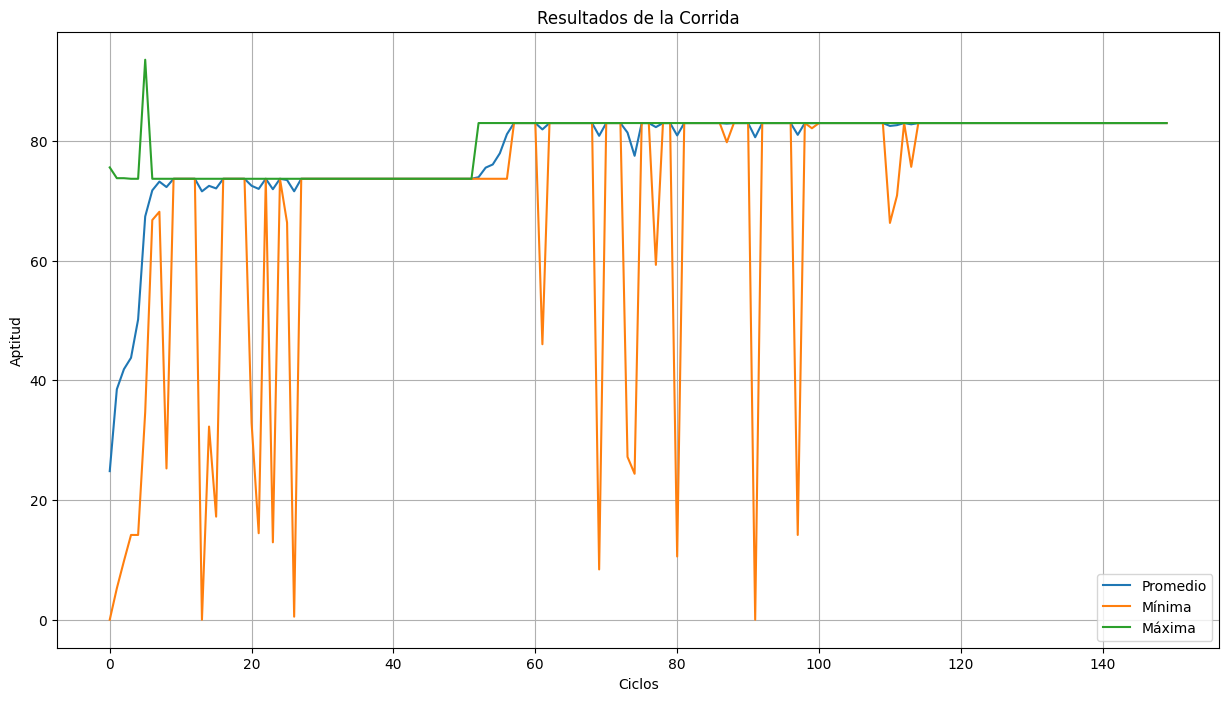

In [9]:
#@title MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8))
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMinAptitud)
plt.plot(ciclosMaxAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud')
plt.legend(['Promedio', 'Mínima', 'Máxima'], loc='lower right')
plt.grid(True)
plt.show()


In [10]:
#@title MOSTRAR GRAFICO DE POSICIONES DE LOS INDIVIDUOS CICLO x CICLO

# Librerías especiales para usar
from matplotlib import animation, rc
from IPython.display import HTML

# método que se usa para generar gradiente de colores
def colorFader(c1, c2, mix=0.0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

# Método que se ejecuta por cada frame para mostrar
def updatePlot(i, ciclosPos, scat, axi, posMejorCorrida, cicloMejorCorrida):
    if axi is None or ciclosPos is None:
      return scat,

    axi.set_xlabel('Ciclo: ' + str(i), fontsize=12)
      # Si no es el último ciclo, muestra también el global
    if i<len(ciclosPos):
      if len(ciclosPos[i])>0:
          if MOSTRAR_HISTORICO_MOVIMIENTO:
              # Coloca nuevas posiciones correspondientes al ciclo
              # Separa las coordenadas x, y de las posiciones en el ciclo i
              X, Y = zip(*ciclosPos[i])
              ## --en Azul: posiciones de las particulas de cada ciclo
              axi.scatter(X, Y, color='blue')
          else:
              # Hace mover a las Partículas
              scat.set_offsets(ciclosPos[i])

    if i>=cicloMejorCorrida:
      if posMejorCorrida is not None:
          ## --en Violeta: Mejor posición de las partículas
          if len(posMejorCorrida) == 2 and isinstance(posMejorCorrida[0], int) and  isinstance(posMejorCorrida[1], int):
              axi.scatter(posMejorCorrida[0], posMejorCorrida[1], color='violet', s=100)
          else:
              X, Y = zip(*posMejorCorrida)
              axi.scatter(X, Y, color='violet', s=100)

    # Devuelve una lista de "artistas" para dibujar,
    # en este caso es sólo uno por lo que se pone una coma final
    return scat,

# Función para preparar el gráfico
def PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosPos, partMejorCorrida, cicloMejorCorrida, textoTitulo, textoDesc):

    fig = plt.figure(figsize=(12,6), dpi=80)
    #ax = fig.add_subplot(111)
    ax = mapa.genGrafico("2D", fig, False)
    plt.close()

    # Define el tamaño de la figura
    ax.axis([MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ])

    # Separa las coordenadas x, y de las posiciones en el ciclo inicial
    X, Y = zip(*ciclosPos[0])
    ## --en Azul: posiciones de las posiciones de cada ciclo
    scat = ax.scatter(X, Y, color='blue')

    # Muestra título y texto debajo
    ax.set_title(textoTitulo)
    #ax.set_ylabel(textoDesc, fontsize=11)

    # Luego setea la animación usando los dos métodos anteriores
    cant = len(ciclosPos)+1
    ani = animation.FuncAnimation(fig, updatePlot,
                                  frames=cant, interval=cant,
                                  fargs=(ciclosPos, scat, ax, partMejorCorrida, cicloMejorCorrida),
                                  blit=True, repeat=False)

    return ani

# Define la configuración para el gráfico
MOSTRAR_HISTORICO_MOVIMIENTO = False
textoTitulo = "Posición de los Individuos de la Corrida ciclo x ciclo"
textoDesc = '\n** Posición Máximo Óptimo a buscar : ' + str(mapa.posMaximoGlobal) + ' { ' +  str(mapa.valMaximoGlobal) +' } **'
textoDesc = textoDesc + '\n== Mejor Individuo: ' + str(mejorIndCorrida) + ' { ' + str(round(mejorIndCorrida.fitness.values[0], 3)) + ' } =='
textoDesc = textoDesc + '\n-- Colores:  Máximos Locales (más ROJO PEOR aptitud, y más VERDE es MEJOR aptitud) - '
textoDesc = textoDesc + '\n-- Individuos (AZUL) - Mejor Individuo (VIOLETA) -- '

# Prepara el gráfico
ani = PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosIndiv, mejorIndCorrida, mejorIndCorrida_ciclo, textoTitulo, textoDesc)

# Nota: esto se agega para que funcione en Google Colab
rc('animation', html='jshtml')
display(ani)
print(textoDesc)

Output hidden; open in https://colab.research.google.com to view.